# Lab Imbalanced Data

We will be using the files_for_lab/customer_churn.csv dataset to build a churn predictor.

*Instructions*
1. Load the dataset and explore the variables.
2. We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.
3. Extract the target variable.
4. Extract the independent variables and scale them.
5. Build the logistic regression model.
6. Evaluate the model.
7. Even a simple model will give us more than 70% accuracy. Why?
8. Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply imblearn.over_sampling.SMOTE to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

## Imports

In [1]:
import imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

In [2]:
customers = pd.read_csv('files_for_lab/customer_churn.csv')
customers.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# 2 lets just start with the suggest columns to use - if time can always come back to the rest of the data to see if it is useful...
customers = customers[['SeniorCitizen','tenure','MonthlyCharges','Churn']]

In [4]:
# initial thoughts 
# - SeniorCitizen will they be more or less likely to churn?
# - tenure, longer duration customers I suspect would be less likely to churn
# - monthlycharges, maybe the higher the charge the more likely the churn

In [5]:
customers.dtypes

SeniorCitizen       int64
tenure              int64
MonthlyCharges    float64
Churn              object
dtype: object

In [6]:
# we have all numerical values, at least in this initial dataset apart from our target which is Yes/No - lets convert this to 0/1 but first lets check for nulls

In [7]:
customers.isna().sum() # all good on the null front...

SeniorCitizen     0
tenure            0
MonthlyCharges    0
Churn             0
dtype: int64

In [8]:
# actually, lets make column names lower first...
customers.columns = list(map(lambda x:x.lower(),customers.columns))

In [9]:
yesno = {'Yes':1,'No':0}
customers['churn'] = customers['churn'].map(yesno)

In [10]:
customers.head()

,seniorcitizen,tenure,monthlycharges,churn
0,0,1,29.85,0
1,0,34,56.95,0
2,0,2,53.85,1
3,0,45,42.30,0
4,0,2,70.70,1


In [11]:
customers.shape

(7043, 4)

In [12]:
customers.describe()

,seniorcitizen,tenure,monthlycharges,churn
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.265370
std,0.368612,24.559481,30.090047,0.441561
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,0.000000
50%,0.000000,29.000000,70.350000,0.000000
75%,0.000000,55.000000,89.850000,1.000000
max,1.000000,72.000000,118.750000,1.000000


In [13]:
y = customers[['churn']]
X = customers.drop(['churn'],axis=1)

In [14]:
y[y.churn == 1].sum() / len(y) # 26% have churned - would you believe it, we have... dun, dun dun... imblance! We also see this in the describe for mean churn...

churn    0.26537
dtype: float64

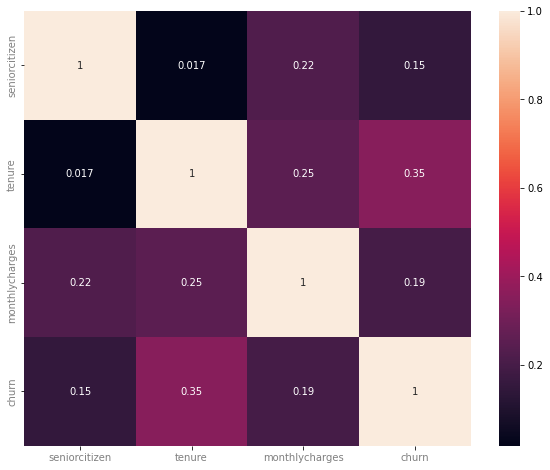

In [15]:
correlations_matrix = customers.corr()
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.heatmap(correlations_matrix.apply(abs), annot=True)
for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("grey")
    tick_label.set_fontsize("10")
for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("grey")
    tick_label.set_fontsize("10")
plt.show()

*charts...they make the workbook look good*

...though added after the running the models but figured I shoulda checked even though we were given the columns to use. At first glance I was surprised tenure had low (from colour) correlation with churn...though it was just a negative correlation. applying abs to the correlation matrix fixes the heatmap. confirms initial suspcision that tenure was the most correlated with churn but our senior citizen and monthly charges are also somewhat correlated.

In [107]:
# lets xy split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

# Scaling data
transformer = MinMaxScaler().fit(X_train)
X_train_normalized = transformer.transform(X_train)
X_train_norm = pd.DataFrame(X_train_normalized)


# no categorical data currently, lets just set the variable to keep edits down
#X_train_transformed = np.concatenate((X_train_norm, X_train_cat), axis=1)
X_train_transformed = X_train_norm
X_train_transformed.columns = ['seniorcitizen','tenure','monthlycharges']


#classification = LogisticRegression(random_state=0, solver='lbfgs',
#                  multi_class='multinomial').fit(X_train_transformed, y_train.values.ravel())
LR = LogisticRegression(random_state=0, solver='lbfgs')
LR.fit(X_train_transformed, y_train.values.ravel())

X_test_num = X_test.select_dtypes(np.number)

#apply the transformer without refit to our test set
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm.columns = ['seniorcitizen','tenure','monthlycharges']

#display(LR.score(X_test_norm, y_test))

# no categorical datas
    #X_test_categorical = X_test.select_dtypes(object)
    #X_test_categorical = X_test_categorical.drop(['title'],axis=1)
    #X_test_cat = pd.get_dummies(X_test_categorical, columns=['category'], drop_first=True)

    #display(list(zip(list(X_train_cat.columns), list(X_test_cat.columns))))
    #X_test_cat.head()

In [108]:

pred = LR.predict(X_test_norm)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))
confusion_matrix(y_test, pred)

precision:  0.7012987012987013
recall:  0.4509394572025052
f1:  0.5489199491740788


array([[1190,   92],
       [ 263,  216]], dtype=int64)

In [109]:
LR.score(X_test_norm, y_test)

0.7984099943214082

### Even a simple ~model~ wodel will give us more than 70% accuracy. Why?

As only around a quarter of the customers will churn, even a model that predicting no churn for everyone will score over 70% so our wodel at this point is just a slight improvement over this.

### Punk Rock tried to kill the metal
### But they failed, as they were **SMOTE** to the ground

In [112]:
rec = []
#for i in range(0,500):
sm = SMOTE(random_state=97,k_neighbors=21)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_transformed,y_train.values.ravel()) # need to ravel to prevent dirty warnings...
X_train_SMOTE.shape

LR2 = LogisticRegression(max_iter=1000)
LR2.fit(X_train_SMOTE, y_train_SMOTE)
pred = LR2.predict(X_test_norm)

rec.append((i,(recall_score(y_test,pred))))
print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.5167597765363129
recall:  0.7724425887265136
f1:  0.6192468619246861


In [111]:
rec = pd.DataFrame(rec, columns=['Iteration','Recall'])
rec[rec['Recall']==rec['Recall'].max()]

,Iteration,Recall
0,499,0.772443


In [113]:
confusion_matrix(y_test,pred)

array([[936, 346],
       [109, 370]], dtype=int64)

In [59]:
LR2.score(X_test_norm, y_test)

0.740488358886996

#### *at the cose of precision we've significantly improved recall*

### Oversampling

In [40]:
from sklearn.utils import resample

In [41]:
# oversampling / undersampling is only to be done on the TRAINING set
# our test set still must reflect reality!
X_train_norm=X_train_norm.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
train = pd.concat([X_train_norm, y_train],axis=1)

In [42]:
display(train.isna().sum())
display(X_train_norm.isna().sum())
display(y_train.isna().sum())

seniorcitizen     0
tenure            0
monthlycharges    0
churn             0
dtype: int64

seniorcitizen     0
tenure            0
monthlycharges    0
dtype: int64

churn    0
dtype: int64

In [43]:
# separate majority/minority classes
no_churn = train[train['churn']==0]
yes_churn = train[train['churn']==1]

In [44]:
display(no_churn.shape)
display(yes_churn.shape)

(3892, 4)

(1390, 4)

In [45]:
# oversample minority
yes_churn_oversampled = resample(yes_churn, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_churn),#<- make both sets the same size
                                    random_state=0)

In [46]:
# both sets are now of a reasonable size
display(no_churn.shape)
display(yes_churn_oversampled.shape)

(3892, 4)

(3892, 4)

In [47]:
train_oversampled = pd.concat([no_churn,yes_churn_oversampled],axis=0)
train_oversampled.tail()

,seniorcitizen,tenure,monthlycharges,churn
3867,1.0,0.027778,0.754858,1
4161,1.0,0.222222,0.206776,1
2804,0.0,0.347222,0.706029,1
768,0.0,0.680556,0.805182,1
3969,0.0,0.097222,0.009965,1


In [48]:
y_train_over = train_oversampled['churn'].copy()
X_train_over = train_oversampled.drop('churn',axis = 1).copy()

In [51]:
LR3 = LogisticRegression(max_iter=1000)
LR3.fit(X_train_over, y_train_over)
pred = LR3.predict(X_test_norm)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.5162659123055162
recall:  0.7620041753653445
f1:  0.6155143338954469


In [52]:
confusion_matrix(y_test,pred)

array([[940, 342],
       [114, 365]], dtype=int64)

In [56]:
LR3.score(X_test_norm, y_test)

0.7410562180579217

*Yeah, score still sus...also, my results are exactly what I had for SMOTE so...I dun gon mucked up